# Functions

**Generate the B graph**

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import random
from sklearn.metrics import f1_score
from time import time
import matplotlib.pyplot as plt
from numpy.ma.extras import average
from sklearn.metrics import confusion_matrix

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcdefaults()

### Data Generation Functions

In [27]:
def B_mat_symmetric(a, p):
    '''To generate a symmetric toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/super-diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
        np.fill_diagonal(result[:,i:], -1*a[i]) # Super-diagonals
    return result


def B_mat_lowertriangular(a, p):
    '''To generate a lower triangular toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
    return result


def cov_x(p):
    """ Generate the covariance matrix for x"""
    sigma_x = np.eye(p)
    return sigma_x


def cov_y(sigma_x, B):
    """ Generate covariance matrix for Y i.e. (B^(-1).X.B^(-T)) since Y=B^(-1).X"""
    B_inv = np.linalg.solve(B, np.eye(B.shape[0]))
    sigma_y = B_inv@sigma_x@B_inv.T
    return sigma_y


def generate_y(mean_y, sigma_y, n_samples):
    """ Generate samples of Y"""
    y_samples = multivariate_normal.rvs(mean=mean_y, cov=sigma_y, size=n_samples)
    return y_samples
    
    
def samp_cov(y_samples):
    """ Generating sample covariance matrix """
    n_samples = len(y_samples)
    samp_cov_y = np.sum(np.array([np.outer(y_samples[i],y_samples[i]) for i in range(n_samples)]), axis=0)/n_samples 
    return samp_cov_y


def soft(x, y):
    return np.sign(x) * np.maximum(np.abs(x) - y, 0)


def threshold(vec, threshold_value=0.002):
    vec1 = vec.copy()
    vec1[np.abs(vec) < threshold_value] = 0
    return vec1


def binarize_matrix(matrix):
    '''Converts non-zero elements to 1 and keeps zeros as zeros.'''
    binary_matrix = np.where(matrix != 0, 1, 0)
    return binary_matrix


def compute_recovery_rate_numpy(a_binary, true_a_binary):
    joint_ones = np.sum((a_binary == 1) & (true_a_binary == 1)) # True positives + False positives
    ones_true_a = np.sum(true_a_binary == 1) # True positives
    if ones_true_a == 0:
        return 0
    return joint_ones / ones_true_a


def create_sparse_vec_pos_def_2(dim, nonzeros, diag=20):
    ''' Function to create sparse vector(p x 1) which can generate symmetric +ve definite toeplitz matrix'''
    vec = np.zeros((dim,))
    vec[0] = diag
    nonzeros -= 1
    # selection of indicies with the non-zero entry (random selection)
    non_zero_indices = random.sample(range(1,dim),nonzeros)
    for idx in non_zero_indices:
        # Randomly assign values to non-zero entries 
        vec[idx] = random.randint(1,5)
    return vec


### Different functions for ADMM ###

def f1(a, S, sigma_x, rho, a2, mu1, regularized = False):
    """ Function evaluation for Newton method with regularization term based on ADMM
        Tr[S.Theta_y] - logdet(Theta_y) + rho/2*||a1 - a2 + mu1||_1"""
    p = S.shape[0]
    a.reshape((-1,))
    B = B_mat_symmetric(a, p)
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    if regularized:
        # Added [1:] since we don't want to regularize a0
        reg_term = (rho/2)*np.linalg.norm(a[1:]-a2+mu1) 
    else:
        reg_term = 0
    return np.trace(S@B.T@theta_x@B)-np.log(np.linalg.det(B.T@theta_x@B))+reg_term 


def f2(a, lam):
    """ Function evaluation of regularization term """
    return lam*np.linalg.norm(a[1:],1)
    
    
def f(a, S, sigma_x):
    a.reshape((-1,))
    B = B_mat_symmetric(a, S.shape[0])
    sigma_x_inv = np.linalg.solve(sigma_x, np.eye(S.shape[0]))
    return np.trace(S@B.T@sigma_x_inv@B) - np.log(np.linalg.det(B.T@sigma_x_inv@B))

Metrics

In [28]:
def kll(a, a_hat, sigma_x):
    ''' Computing the KL loss for the covariance matrices of Y'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    return np.trace(sigma_y@theta_y_hat) - np.log(np.linalg.det(sigma_y@theta_y_hat)) - p

def rkll(a, a_hat, sigma_x):
    ''' Computing the reverse KL loss for the covariance matrices of Y'''
    return kll(a_hat, a, sigma_x)

def rte(a, a_hat, sigma_x):
    ''' Computing the relative trace error loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    return abs(1 - (np.trace(theta_y_hat)/np.trace(theta_y)))

def norm_loss(a, a_hat, sigma_x):
    ''' Computing the norm loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    fro = np.linalg.norm(theta_y-theta_y_hat,ord='fro')
    spe = np.linalg.norm(theta_y-theta_y_hat,ord=2)
    l1 = np.linalg.norm(theta_y-theta_y_hat,ord=1)
    return fro, spe, l1

def scores(a, a_hat, threshold_value):
    ''' Computing the support recovery based scores for the precision matrix'''
    a_thr = threshold(a_hat, threshold_value=threshold_value) # Apply the threshold
    a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
    true_a_binary = binarize_matrix(a)  # True Support Vector
    cm = confusion_matrix(true_a_binary, a_binary)
    tn,fp,fn,tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    accuracy = (tn + tp)/np.sum(cm)
    specificity = (tn)/(tn + fp) # TN/(TN+FP)
    sensitivity = (tp)/(tp + fn) # TP/(TP+FN)
    MCC = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return accuracy, specificity, sensitivity, MCC, cm

### Gradient Computation

In [ ]:
def grad_f(x, S, sigma_x, rho, a2, mu1, regularized = False):
    ''' Computing gradient for f1(x) = Tr(S B(x) T B(x)) + log(det(B(x) T B(x)))
        both regularized and unregularized, where B is symmetric'''
    p = S.shape[0] # Dimensions
    B = B_mat_symmetric(x, p) # Generating B matrix with a given x
    B_inv = np.linalg.solve(B, np.eye(p))
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    
    if regularized:
        k = np.zeros_like(x)
        k[1:] = x[1:]-a2+mu1
    else:
        k = np.zeros_like(x)
    
    gradient = np.zeros((p,))
    for i in range(p):
        Ti = np.zeros((p,p))
        if i==0:
            np.fill_diagonal(Ti, 1)
            gradient[i] = 2*np.trace((S@B@theta_x@Ti) - (B_inv@Ti))
        else:
            np.fill_diagonal(Ti[i:], -1) # Sub-diagonals
            np.fill_diagonal(Ti[:,i:], -1) # Super-diagonals
            gradient[i] = 2*np.trace((S@B@theta_x@Ti) - (B_inv@Ti)) + (rho*k[i])
    return gradient


def hessian_f(x, S, sigma_x, rho, regularized = False):
    ''' Computing Hessian for f1(x) = Tr(S B(x) T B(x)) + log(det(B(x) T B(x)))
        both regularized and unregularized, where B is symmetric'''
    p = S.shape[0]
    B = B_mat_symmetric(x, p)
    B_inv = np.linalg.solve(B, np.eye(p))  
    # B_inv = np.linalg.solve(B, stack all Tis)  
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    
    hessian = np.zeros((p,p))
    for i in range(p):
        Ti = np.zeros((p,p))
        if i==0:
            np.fill_diagonal(Ti, 1)
        else:
            np.fill_diagonal(Ti[i:], -1) # Sub-diagonals
            np.fill_diagonal(Ti[:,i:], -1) # Super-diagonals
        for j in range(p):
            Tj = np.zeros((p,p))
            if j==0:
                np.fill_diagonal(Tj, 1)
            else:
                np.fill_diagonal(Tj[j:], -1) # Sub-diagonals
                np.fill_diagonal(Tj[:,j:], -1) # Super-diagonals
            hessian[i,j] = 2*(np.trace(S@Ti@theta_x@Tj) + np.trace(B_inv@Ti@B_inv@Tj))
    if regularized:
        reg = rho*np.eye(p)
        reg[0,0] = 0
        hessian+=reg
    return hessian

###  Newtons Method

In [30]:
def compute_newton_step(gradient, hessian):
    """
    Computes the Newton step and decrement.

    Parameters:
    gradient (np.array): Gradient vector.
    hessian (np.array): Hessian matrix.

    Returns:
    delta_x_nt (np.array): Newton step.
    lambd (float): Newton decrement.
    """
    delta_x_nt = -np.linalg.solve(hessian, gradient)  # Newton step
    lambd_sqr = np.dot(gradient.T, hessian@gradient)  # Newton decrement
    return delta_x_nt, lambd_sqr

def backtracking_line_search(f, gradient, x, delta_x_nt, S, sigma_x, rho, a2, mu1,
                             regularized=False, alpha=0.01, beta=0.5):
    """
    Backtracking line search to ensure sufficient decrease.

    Parameters:
    f (function): Function to minimize.
    gradient (np.array): Gradient vector.
    x (np.array): Current point.
    delta_x_nt (np.array): Newton step.
    alpha (float): Alpha parameter for backtracking.
    beta (float): Beta parameter for backtracking.

    Returns:
    t (float): Step size.
    """
    t = 1  # Start with full step size
    p = S.shape[0]
    x_ = x + t * delta_x_nt
    e_val, e_vec = np.linalg.eig(B_mat_symmetric(x_, p))
    i = 0
    while not np.all(e_val>0): 
        t *= beta # Reduce step size so that x + del_x is PSD
        x_ = x + t * delta_x_nt
        e_val, e_vec = np.linalg.eig(B_mat_symmetric(x_, p))
        i+=1
        if i>20:
            t = 0
            print('Backtracking line search (I) went beyond 20 iterations')
            break
    x_ = x + t * delta_x_nt
    i = 0
    while (f(x_,S,sigma_x,rho,a2,mu1,regularized=regularized)\
           >f(x,S,sigma_x,rho,a2,mu1,regularized=regularized)\
           + alpha*t*np.dot(gradient.T,delta_x_nt)):
        t *= beta  # Reduce step size
        x_ = x + t * delta_x_nt
        if (i>20) or (t==0):
            t = 0
            print('Backtracking line search (II) went beyond 20 iterations')
            break
    return t


def projection_Rp(x):
    y = np.maximum(x, np.zeros_like(x))
    return y


def newton_method(f, x0, S, sigma_x, rho, a2, mu1, epsilon=1e-6, alpha=0.01, beta=0.5,
                  regularized=False, backtracking=False, projection=False):
    """
    Implements Newton's method for optimization.

    Parameters:
    f (function): Function to minimize.
    grad_f (function): Gradient function.
    hessian_f (function): Hessian function.
    x0 (np.array): Initial point.
    epsilon (float): Stopping criterion for Newton decrement.
    alpha (float): Alpha parameter for backtracking.
    beta (float): Beta parameter for backtracking.

    Returns:
    x (np.array): Optimized point.
    """
    x = x0
    i = 0
    while True:
        gradient = grad_f(x, S, sigma_x, rho, a2, mu1, regularized=regularized)
        hessian = hessian_f(x, S, sigma_x, rho, regularized=regularized)
        
        # Compute Newton step and decrement
        delta_x_nt, lambd_sqr = compute_newton_step(gradient, hessian)
        
        # Stopping criterion
        if lambd_sqr / 2 <= epsilon:
            print('Stopping Criteria Met')
            print(lambd_sqr, delta_x_nt)
            print(i)
            break

        # Backtracking line search
        if backtracking:
            print("line search")
            t = backtracking_line_search(f, gradient, x, delta_x_nt, S, sigma_x, rho, a2, mu1,
                                         regularized=regularized, alpha=alpha, beta=beta)
        else:
            t = 1
#         print(t)
            
        # Update x
        x_old = x.copy()
        x = x + t*delta_x_nt

        # Project x on R+
        if projection:
            x = projection_Rp(x)
        
        if i%10==0:
            print(lambd_sqr, delta_x_nt)
            print(i)
            
        if (i>=50):
            print('Newton algorithm finished 50 iterations')
            break
        
        if (i>1) and (np.linalg.norm(x_old-x)<=epsilon):
            print('not much change in x observed')
            print(i)
            break
        i+=1
    return x


### Pseudo Version of ADMM (Since f1 is not in closed form)

#### ADMM

In [31]:
def ADMM_newton(f, iterations, rho, lambda_param, S, sigma_x, a, epsilon=1e-6,
                alpha=0.5, beta=0.7, regularized=False, backtracking=False,
                projection=False, perturbed=False, tol=1e-4):
    p = S.shape[0]
    e0 = np.zeros((p,))
    e0[0] = 1
    a1 = e0.copy()
    a2 = np.zeros((p-1,))
    mu1 = np.zeros((p-1,))
    if perturbed:
        a1 = a + 0.1*np.random.randn(p)
        a2 = a[1:] + 0.1*np.random.randn(p-1)
    if regularized:
        print('Regularized - ADMM + Newton')
        for i in range(iterations):       
            print('='*50, "iteration ", i, '='*50)
            a2_old = a2.copy()
            a1_ = newton_method(f, a1, S, sigma_x, rho, a2, mu1, epsilon=epsilon,
                                alpha=alpha, beta=beta, regularized=regularized,
                                backtracking=backtracking, projection=projection)
            print("Completed Newton Iteration")
            a2_ = soft(a1_[1:]+mu1,lambda_param/rho)
            mu1_ = mu1 + (a1_[1:]-a2_)
            a1, a2, mu1 = a1_, a2_, mu1_

            primal_res = np.linalg.norm(a1[1:] - a2)
            dual_res = np.linalg.norm(rho * (a2 - a2_old))

            if primal_res <= tol and dual_res <= tol:
                break

    else:
        print('Unregularized - Newton')
        for i in range(iterations):       
            print('='*50, "iteration ", i, '='*50)
            a1_ = newton_method(f, a1, S, sigma_x, rho, a2, mu1, epsilon=epsilon,
                                alpha=alpha, beta=beta, regularized=regularized,
                                backtracking=backtracking, projection=projection)
            a1 = a1_
    return a1, a2, mu1

### Simulations - Symmetric Case

#### Initialization for multiple simulations

In [32]:
p = 50  # Dimensions of the square toeplitz matrix
d = 5   # Sparsity of the (px1) vextor => no of non zero entries in (2p x 1) = 2d-1
const = 15  # multiplicative factor for number of samples
n_samples = int(const*(d*np.log(p))) # number of samples for the problem setup
num_rep = 10  # number of repetitions of the algorithm

rho = 1
lambda_param = 0.05
iterations = 50

regularize = True
backtrack = True
project = True
perturb = False
n_samples

293

In [33]:
data = {}

print('Dimensions of Matrix = ', p, 'Sparsity = ', d)
for rep in range(num_rep):
    a = create_sparse_vec_pos_def_2(p, d, diag= d*10)
    B0 = B_mat_symmetric(a, p)
    B0_inv = np.linalg.inv(B0)
    sigma_x = cov_x(p)
    sigma_y = cov_y(sigma_x,B0)
    y_samp = generate_y(np.zeros((p,)), sigma_y, n_samples)
    S = samp_cov(y_samp)
    
    total_t1 = time()
    print('_'*50, 'Run = ', rep, '_'*50)
    a1, a2, mu1 = ADMM_newton(f1, iterations, rho, lambda_param, S, sigma_x, a, epsilon=1e-4,
                              alpha=0.1, beta=0.7, regularized=regularize, backtracking=backtrack,
                              projection=project, perturbed=perturb)
    total_t2 = time()
    print('Total time taken for a run = ', total_t2 - total_t1)
    
    run_data = {'p': p, 'd':d, 'const':const, 'num_samples':n_samples, 'lambda':lambda_param, 'rho': rho,
                'iterations': iterations, 'a': a, 'samp_y':y_samp, 'f_reg':regularize, 'f_back':backtrack,
                'f_proj':project, 'f_perturb':perturb, 'a1':a1, 'a2':a2, 'mu1':mu1}
    data[rep] = run_data

Dimensions of Matrix =  50 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
999587.441465863 [ 9.99175596e-01  7.48166557e-06  9.10210548e-06  2.57008580e-06
  1.11607825e-04  2.33988625e-05  4.21727193e-05  8.61634771e-06
  1.94000138e-05  1.06055834e-05  1.12970459e-05  6.38972318e-06
 -5.47992976e-06  6.20747034e-05  6.89379296e-07 -5.39282156e-06
 -7.45603389e-07  2.11721185e-05  1.74656969e-05 -6.60496739e-06
 -3.64547142e-06  1.72074089e-05 -3.81372794e-06 -6.21500985e-06
 -1.31222974e-05  1.65740358e-05  6.13979232e-06  8.49049334e-06
 -6.14462262e-07  1.53912182e-05  1.27480514e-05  1.84612187e-05
  9.32723472e-06  5.63739980e-07  1.96042958e-05  9.53821093e-05
 -1.14902353e-05  1.33084419e-05  2.81786895e-05  2.73227090e-05
 -4.89915116e-06  1.871188

KeyboardInterrupt: 

In [19]:
keys = list(data[0].keys())
best_thr = []
best_rate = []
best_acc = []
best_f1 = []
best_cm = []

kll_const = []
rkll_const = []
rte_const = []
norm_const = []
scores_const = []

threshold_range = 0.01*np.arange(101)
for rep in range(num_rep):
    a = data[rep][keys[7]]
    a1 = data[rep][keys[-3]]
    true_a_binary = binarize_matrix(a)
    thr_rate = []
    thr_cm = []
    thr_acc = []
    thr_f1 = []
    for thr in threshold_range:  
        a_thr = threshold(a1, threshold_value=thr) # Apply the threshold
        a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
        rate = compute_recovery_rate_numpy(a_binary, true_a_binary)  # Computing recovery rate
        cm = confusion_matrix(true_a_binary, a_binary)
        accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)

        thr_rate += [rate]
        thr_cm += [cm]
        thr_acc += [accuracy]
        thr_f1 += [f1_score(true_a_binary, a_binary)]
    idx = np.argmax(np.array(thr_acc))
    best_thr += [threshold_range[idx]]
    best_rate += [thr_rate[idx]]
    best_acc += [thr_acc[idx]]
    best_f1 += [thr_f1[idx]]
    best_cm += [thr_cm[idx]]
    a_thr = threshold(a1, threshold_value=threshold_range[idx]) # Apply the threshold
    a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
    
    kll_const += [kll(a, a_thr, sigma_x)]
    rkll_const += [rkll(a, a_thr, sigma_x)]
    rte_const += [rte(a, a_thr, sigma_x)]
    norm_const += [norm_loss(a, a_thr, sigma_x)]
    scores_const += [scores(a, a1, threshold_value=threshold_range[idx])]

In [20]:
fro_norm_const = [norm_const[i][0] for i in range(num_rep)]
spec_norm_const = [norm_const[i][1] for i in range(num_rep)]
l1_norm_const = [norm_const[i][2] for i in range(num_rep)]

In [21]:
[average(best_acc), average(best_f1), average(best_rate), average(kll_const), average(rkll_const), average(rte_const)]

[0.99,
 0.9444444444444444,
 0.9,
 0.14891171359917835,
 0.14884468073421644,
 0.020760436779416292]

Finding the best lambda, rho for different p – [25, 50, 75, 100, 200]

In [34]:
import itertools

In [35]:
class SolverArgs:
    def __init__(self, p=50, d=5, const=15, rho=1.0, lambda_param=0.05, iterations=50,
                 regularize=True, backtrack=True, project=True, perturb=False, num_rep=10,):
        self.p = p
        self.d = d
        self.const = const
        self.rho = rho
        self.lambda_param = lambda_param
        self.iterations = iterations
        self.regularize = regularize
        self.backtrack = backtrack
        self.project = project
        self.perturb = perturb
        self.num_rep = num_rep

In [ ]:
class Solver:
    def __init__(self, args: SolverArgs):
        self.args = args

    def solve(self,epsilon=1e-4,alpha=0.1,beta=0.7,):
        p = self.args.p
        d = self.args.d
        const = self.args.const
        rho = self.args.rho
        lambda_param = self.args.lambda_param
        iterations = self.args.iterations
        regularize = self.args.regularize
        backtrack = self.args.backtrack
        project = self.args.project
        perturb = self.args.perturb
        num_rep = self.args.num_rep

        n_samples = int(const * (d * d * np.log(p)))
        data = {}

        print('Dimensions of Matrix = ', p, 'Sparsity = ', d)
        for rep in range(num_rep):
            a = create_sparse_vec_pos_def_2(p, d, diag=d * 10)
            B0 = B_mat_symmetric(a, p)
            # B0_inv = np.linalg.inv(B0)
            sigma_x = cov_x(p)
            sigma_y = cov_y(sigma_x, B0)
            y_samp = generate_y(np.zeros((p,)), sigma_y, n_samples)
            S = samp_cov(y_samp)

            total_t1 = time()
            print('_' * 50, 'Run = ', rep, '_' * 50)
            a1, a2, mu1 = ADMM_newton(
                f1,
                iterations,
                rho,
                lambda_param,
                S,
                sigma_x,
                a,
                epsilon=epsilon,
                alpha=alpha,
                beta=beta,
                regularized=regularize,
                backtracking=backtrack,
                projection=project,
                perturbed=perturb
            )
            total_t2 = time()
            print('Total time taken for a run = ', total_t2 - total_t1)

            run_data = {
                'p': p,
                'd': d,
                'const': const,
                'num_samples': n_samples,
                'lambda': lambda_param,
                'rho': rho,
                'iterations': iterations,
                'a': a,
                'samp_y': y_samp,
                'f_reg': regularize,
                'f_back': backtrack,
                'f_proj': project,
                'f_perturb': perturb,
                'a1': a1,
                'a2': a2,
                'mu1': mu1,
                'sigma_x': sigma_x
            }
            data[rep] = run_data

        return data
    
    def evaluate(self, data):
        num_rep = self.args.num_rep
        keys = list(data[0].keys())
        threshold_range = 0.01 * np.arange(101)

        best_thr = []
        best_rate = []
        best_acc = []
        best_f1 = []
        best_cm = []

        kll_const = []
        rkll_const = []
        rte_const = []
        norm_const = []
        scores_const = []

        for rep in range(num_rep):
            a = data[rep][keys[7]]
            a1 = data[rep][keys[-4]]
            sigma_x = data[rep][keys[-1]]
            true_a_binary = binarize_matrix(a)
            thr_rate = []
            thr_cm = []
            thr_acc = []
            thr_f1 = []

            for thr in threshold_range:
                a_thr = threshold(a1, threshold_value=thr)
                a_binary = binarize_matrix(a_thr)
                rate = compute_recovery_rate_numpy(a_binary, true_a_binary)
                cm = confusion_matrix(true_a_binary, a_binary)
                accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)

                thr_rate.append(rate)
                thr_cm.append(cm)
                thr_acc.append(accuracy)
                thr_f1.append(f1_score(true_a_binary, a_binary))

            idx = np.argmax(np.array(thr_acc))
            best_thr.append(threshold_range[idx])
            best_rate.append(thr_rate[idx])
            best_acc.append(thr_acc[idx])
            best_f1.append(thr_f1[idx])
            best_cm.append(thr_cm[idx])

            a_thr = threshold(a1, threshold_value=threshold_range[idx])
            a_binary = binarize_matrix(a_thr)

            kll_const.append(kll(a, a_thr, sigma_x))
            rkll_const.append(rkll(a, a_thr, sigma_x))
            rte_const.append(rte(a, a_thr, sigma_x))
            norm_const.append(norm_loss(a, a_thr, sigma_x))
            scores_const.append(scores(a, a1, threshold_value=threshold_range[idx]))

        metrics = {
            'avg_acc': average(best_acc),
            'avg_f1': average(best_f1),
            'avg_rate': average(best_rate),
            'avg_kll': average(kll_const),
            'avg_rkll': average(rkll_const),
            'avg_rte': average(rte_const),
            'avg_fro': average([n[0] for n in norm_const]),
            'avg_spec': average([n[1] for n in norm_const]),
            'avg_l1': average([n[2] for n in norm_const])
        }

        return metrics

In [12]:
defaultArgs = SolverArgs(p=200, num_rep=1)
defaultSolver = Solver(defaultArgs)
temp = defaultSolver.solve()

Dimensions of Matrix =  200 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
63973140.315592736 [ 9.99161379e-01 -3.45842979e-07  6.21703604e-06 -4.77713228e-06
  3.78671114e-06  2.31506563e-06 -1.11923810e-06 -2.52782308e-06
 -4.06106679e-06  1.54779411e-06  7.27399853e-08 -1.19076942e-06
 -8.05539472e-07  1.95406906e-06  1.09024533e-06 -1.47592537e-06
 -1.59108656e-06 -6.47158350e-07 -2.95792091e-06  9.51861713e-06
  6.63684861e-07  1.31079122e-04  6.28115005e-06  9.46582032e-06
 -8.29251930e-08  3.12445009e-06  3.50407226e-06 -1.95105184e-07
 -5.14310143e-06 -2.14601465e-06 -5.71853705e-07  1.05033746e-06
 -2.93654364e-06  1.90656502e-06  4.00954793e-06  1.44794593e-06
 -1.86114605e-06 -2.03846695e-06 -7.15698085e-07  1.17037519e-06
  6.88171035e-06  3.894

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
3.6995638238209647 [ 1.97033804e-01 -9.76478667e-03 -2.77964991e-02 -5.53203633e-02
 -2.44648321e-02 -1.47791966e-02 -9.02066858e-03 -2.43917575e-02
 -4.48526998e-02 -1.06446066e-02  2.37260221e-04 -1.06710949e-02
 -1.02666342e-02 -1.22637290e-02 -6.37976520e-03 -1.22667208e-02
 -1.64430292e-02 -9.72505751e-03 -2.85734558e-02 -4.41608702e-03
 -2.26751472e-03  8.33606359e-01 -1.72746384e-02 -5.92109740e-03
 -1.05716212e-03 -2.03323918e-02 -2.11402696e-02 -1.14818653e-03
 -4.99551348e-02 -1.39476867e-02 -1.77080068e-03 -6.91041451e-03
 -3.14909458e-02 -1.02305001e-02 -2.67083609e-02 -6.37088033e-03
 -2.12702648e-02 -1.86941728e-02 -2.07949979e-02 -8.01651598e-03
 -3.70652131e-02 -2.47116888e-02 -6.98194491e-03 -2.47047316e

KeyboardInterrupt: 

In [38]:
defaultSolver.evaluate(temp)

{'avg_acc': 1.0,
 'avg_f1': 1.0,
 'avg_rate': 1.0,
 'avg_kll': 0.09787207521135599,
 'avg_rkll': 0.09838855014019998,
 'avg_rte': 0.02304534265118585,
 'avg_fro': 1189.5880067151973,
 'avg_spec': 415.6890867564783,
 'avg_l1': 558.5887386839482}

In [42]:
import csv

In [44]:
p_values = [25, 50, 75, 100, 200]
lambda_grid = [0.01, 0.05, 0.1, 0.2]
rho_grid = [0.5, 1.0, 2.0]

results = []

for p in p_values:
    best_loss = float('inf')
    best_params = None

    for lamb, rho in itertools.product(lambda_grid, rho_grid):
        args = SolverArgs(p=p, lambda_param=lamb, rho=rho, num_rep=2)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)

        result_row = {
            'p': p,
            'lambda': lamb,
            'rho': rho,
            **metrics
        }
        results.append(result_row)

        if metrics['avg_kll'] < best_loss:
            best_loss = metrics['avg_kll']
            best_params = result_row

    print(f"Best for p={p}:", best_params)

# Save to CSV
with open('grid_search_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print("Results saved to 'grid_search_results.csv'")


Dimensions of Matrix =  25 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
124948.73616244624 [ 9.99180502e-01 -2.92083673e-05 -6.63849609e-06 -1.21843034e-05
 -7.73988807e-06  9.19803851e-06 -1.08526436e-05  1.54303357e-05
  5.79789776e-06 -2.08161614e-05  1.42267136e-04 -1.11902216e-05
 -9.13814024e-06  1.49692669e-05 -7.25245530e-06 -1.22359288e-05
 -8.69480810e-06 -1.24457081e-05  1.75422009e-04 -3.79647194e-05
  1.24978574e-04 -4.44137356e-05 -4.83223488e-05  1.00382827e-04
 -3.40874216e-05]
0
line search
line search
line search
line search
line search
line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 =================================

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.8772586020627922 [ 3.50653317e-01 -4.30352742e-03 -4.29542733e-02  6.92162494e-01
 -1.03710316e-02 -6.37365217e-03 -3.48018971e-02  3.25574564e-02
 -1.02439696e-01 -2.40316884e-03 -1.09077679e-02 -4.29994460e-03
 -3.59146497e-03 -2.30692759e-02 -1.18490158e-03 -2.02550309e-02
  1.98776490e-02 -1.06576802e-01 -1.21280555e-03 -2.63345523e-02
  6.21641299e-04  9.41033965e-03 -1.56139035e-02 -1.05707277e-02
 -2.80502703e-02 -5.12504664e-03 -2.17224178e-02  9.59925847e-02
 -4.46975183e-02 -1.92492029e-02  1.07633608e+00 -1.15440839e-01
 -4.08394038e-02  7.81693400e-02 -4.60973790e-02  1.42751906e-03
 -1.63905420e-02 -8.35988610e-02 -7.72985076e-02 -6.17013133e-02
 -2.39364094e-03 -4.70495797e-02 -4.99156808e-03 -1.25291144e-02
 -8.79899371e-02 -3.63637084e-02

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
2.7927259998971166 [ 3.09447207e-01 -5.32807467e-03  9.11873384e-01 -1.30537961e-02
  6.78209862e-02 -4.42436203e-03 -9.44282055e-03 -4.74250442e-03
 -1.72217810e-02  2.00238777e-03  5.69639495e-03  1.10109532e-03
 -5.12132837e-03 -2.88040615e-03 -6.17245962e-03  3.35860782e-02
 -9.65786594e-03  1.50596715e-02 -5.18758455e-03 -4.00053348e-03
  2.56812227e-02 -3.30509368e-02  1.01829389e-02 -3.76045284e-03
 -2.21273716e-02 -1.71419040e-02 -5.08912941e-02 -2.63162446e-03
 -2.87508157e-02 -9.15749632e-04  2.20188751e-02  1.12293145e-01
 -2.35335003e-02  4.53731093e-01 -1.39782635e-02  8.80064445e-02
 -2.16793738e-02  5.89761515e-03 -3.59905804e-02 -1.69285741e-02
 -2.54102314e-03 -4.25598296e-02  4.96667555e-03 -4.17965771e-03
  1.15656822e-01 -1.09020659e-03

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.9653778707514297 [ 2.89198079e-02 -1.31636045e-02  1.15764000e-02 -1.42089013e-03
  2.66199092e-03 -1.10997689e-02  2.12499803e-02  1.32619291e-03
 -1.85915802e-03  2.80361495e-02 -1.78348671e-02  1.38307142e-02
 -2.09796215e-02  1.65748639e-02 -8.38855825e-03  1.86373755e-02
 -1.57046258e-02  2.28821971e-02 -4.27001249e-03 -4.01972530e-03
  1.49771979e-02 -3.46927912e-03 -2.35756084e-03 -9.30756741e-03
 -3.78551875e-03  1.90141474e-02 -2.53462928e-03 -4.40828632e-02
 -5.61736461e-03 -3.41789709e-03  1.06273551e-02  1.02463903e-03
  4.53001223e-03 -7.06731365e-03 -3.62445033e-03  7.14215339e-03
 -1.74878428e-02  1.28757158e-02 -2.75629357e-02 -1.68584716e-02
  3.39837363e-03 -2.20873582e-04  1.44798349e-01 -2.26297450e-03
 -1.16061192e-03 -1.88375071e-02

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.05041906924624818 [-0.00445773 -0.05357084 -0.02245298 -0.0371133  -0.05809213 -0.02458194
 -0.00266713 -0.00996291 -0.02782418 -0.00096215 -0.03568183 -0.07394023
 -0.04553446 -0.0135132  -0.04155546 -0.04264489 -0.00328608 -0.05768365
 -0.0805808  -0.04788976 -0.05911556 -0.00566622 -0.0645502  -0.06091861
 -0.00575522 -0.00526813 -0.00408752 -0.01592344 -0.05125627 -0.02621234
 -0.01254549  0.07747083 -0.04286618 -0.04146264 -0.00364193 -0.02958636
 -0.03744701 -0.01014781 -0.03448126 -0.02180436 -0.04338263 -0.0278115
 -0.03242717 -0.0851197  -0.02110924 -0.09904307 -0.01211958 -0.04357501
 -0.01851791 -0.04278983 -0.03823842 -0.02709266 -0.03734107  0.00043984
 -0.00205884 -0.0125245  -0.03215699 -0.01492256 -0.00056033 -0.00473038
 -0.0495507  -0.0

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.8111731332674317 [ 9.87820090e-02 -1.14234824e-02 -1.60000644e-02 -6.79276358e-03
 -6.25876095e-03 -4.09944094e-03 -7.47887090e-03 -5.73930194e-02
 -4.07910933e-02 -2.26074006e-02 -1.70819797e-02 -3.44571985e-02
 -2.38651523e-02 -2.62209400e-02 -5.09167696e-02 -4.87688844e-02
 -2.08000026e-02 -1.73167289e-03 -3.33186890e-02 -2.22006760e-02
 -4.55101019e-03 -1.50986006e-02 -5.23289916e-02 -1.07393359e-02
 -4.47353113e-02 -4.02625732e-03 -2.05352226e-02 -2.61589084e-02
 -6.25798814e-03 -4.05668033e-02  3.95973637e-01 -5.38360293e-02
 -1.79085163e-02 -4.07831518e-02 -2.68301425e-02 -1.62385111e-03
 -3.22978982e-03 -3.80701762e-02 -3.02649466e-03 -9.78061344e-03
 -9.80557613e-03  3.30404606e-01 -1.99961002e-02 -1.68708638e-02
 -5.62094372e-03 -1.69899491e-02

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
1.9216276334664548 [ 5.91966399e-02 -1.12030793e-02  3.21787764e-01 -2.00710091e-02
 -9.62387707e-03 -3.53400632e-03 -2.84024125e-03 -1.16291727e-03
 -8.05751716e-03 -3.46145417e-03 -1.20302075e-02 -1.95563180e-02
 -2.89556996e-02 -9.09069872e-04 -1.69502667e-02 -5.79680918e-03
 -5.22256122e-03 -2.00000986e-02 -1.08077089e-02 -1.21833511e-02
 -1.23151236e-02 -1.11965339e-02 -1.23563345e-02 -1.46436665e-02
 -5.89322547e-03 -8.53915343e-03 -8.62676188e-03 -2.97307934e-03
 -1.52194113e-02 -9.80951473e-04 -1.91855530e-02 -1.33917464e-02
 -1.79285994e-03 -2.36620324e-02 -3.75389279e-04 -4.96386578e-03
 -1.53899438e-02 -1.04593836e-02 -1.44960639e-02 -1.89151550e-03
 -2.64345314e-03 -6.74131646e-03 -3.02748702e-02 -3.40576581e-03
 -8.76630171e-03 -1.14554015e-02

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
1.25438785395032 [ 5.40024269e-01  1.06856212e+00 -1.54454182e-01 -3.54970859e-02
  5.13653342e-03 -4.37618220e-02  2.24668070e-03 -1.63948662e-02
 -5.93900200e-02 -1.97167248e-02 -3.54647719e-02 -8.59680580e-03
 -6.36362165e-03 -3.48382489e-02 -4.01409024e-02 -9.20038598e-03
 -6.52584279e-02 -6.57538714e-02 -1.95486040e-02 -6.09295485e-03
 -5.27481426e-02 -5.72192109e-02 -1.16260320e-01 -4.02470789e-02
 -5.37812220e-02 -4.59788462e-02 -9.13314980e-02 -7.01892206e-02
 -1.24750399e-01 -1.23098240e-01 -1.16626400e-02 -8.51396092e-03
 -1.14472782e-01  8.53847653e-01 -9.94961605e-02 -7.18351453e-02
 -1.31891510e-02 -4.06712626e-03 -3.94990519e-02 -6.12580841e-02
 -2.61578030e-02 -2.61778947e-02 -3.33549787e-02  1.91755247e-03
 -3.88712274e-02 -1.32733037e-02 -

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.8556084186676891 [ 1.00799107e-01 -7.88493879e-02 -2.55599937e-03  4.74080371e-02
 -4.61771109e-02 -3.83360212e-03 -3.27882448e-02 -4.65200295e-02
 -7.81336676e-03 -8.26115384e-02 -7.08453629e-03 -9.67719673e-03
 -1.21290645e-02 -3.47763662e-02 -9.95386269e-03 -3.09319200e-02
 -1.14788941e-03 -4.75238140e-02  4.54176906e-01  3.64182307e-01
 -5.87929808e-02 -2.74273481e-02 -6.40487975e-02 -1.55476922e-02
 -7.75799783e-03 -1.96514243e-03 -3.77835254e-02 -3.23906826e-02
 -3.07489386e-03 -1.70983595e-02 -5.26519425e-03 -1.64878998e-02
 -1.77776612e-02 -5.42137859e-02 -1.90365977e-02 -2.10220699e-02
 -7.46946888e-02 -7.14138293e-02 -3.99069973e-02 -4.05034754e-02
 -5.58096161e-03 -6.12842753e-02 -1.93360335e-02 -2.74363991e-02
 -3.80274401e-02 -6.26029665e-03

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.45696926944882155 [ 1.09942396e-02 -9.21017702e-03  4.75424636e-02 -2.71273227e-03
 -7.41219477e-03 -2.20433754e-02 -2.84517657e-03 -2.58899981e-02
 -1.65866820e-02 -3.27787249e-02 -1.34700244e-02 -1.29982715e-02
 -1.35758276e-02 -4.29172921e-03 -1.04400690e-02 -5.28182548e-03
 -4.71367966e-03 -1.08057872e-02 -2.07188693e-02 -3.47781828e-02
 -2.43221113e-02 -3.99669456e-02 -3.52004175e-02 -5.23708166e-03
 -3.10249344e-02 -5.54629377e-03 -9.11040556e-03 -7.56151489e-03
 -5.91797178e-03 -5.33812315e-03 -7.40761837e-03 -8.90375312e-03
 -1.39659900e-02 -1.62456089e-02 -1.55018040e-03 -7.53834242e-03
 -3.53699338e-03 -8.58064926e-03 -1.88616443e-02 -1.10534922e-02
 -2.65906194e-02 -2.64504978e-03 -3.38045574e-02 -7.18299975e-03
  8.35263472e-02 -9.79390655e-0

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.09060486717663593 [-0.03329109 -0.07799096 -0.03300817 -0.057851   -0.0403857  -0.06258631
 -0.06165058 -0.03394191 -0.01326358 -0.01807933 -0.02606188 -0.0259606
 -0.01599229 -0.01232551 -0.08400019 -0.01217731 -0.04309173 -0.04966315
 -0.04859472 -0.06525248 -0.01516068 -0.03716404 -0.0556793  -0.06837596
 -0.07005553 -0.04967009 -0.03565114 -0.01494139 -0.11418223 -0.0620631
 -0.03054794 -0.01859075 -0.00383994 -0.00460361 -0.07049453 -0.07594246
 -0.05249038 -0.00226617 -0.00664991 -0.03085605 -0.01384224 -0.03489569
 -0.02213414 -0.0114762  -0.06911835 -0.00852634 -0.05206644 -0.01585085
 -0.02136157 -0.03663165 -0.10586296 -0.02299407 -0.00404563 -0.03772576
 -0.00209877 -0.05510475 -0.03224934 -0.03521886 -0.06063356 -0.00557225
 -0.02882513 -0.02

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.15090078841329227 [-1.48414833e-02 -3.44008874e-02 -4.90055469e-02 -3.13038285e-02
 -1.35436521e-02 -1.87321380e-02 -1.17177413e-02 -1.17247925e-02
 -6.85844529e-05  1.28332351e-03 -6.21000376e-03 -4.92460486e-03
 -1.62958487e-02 -1.20629900e-02 -2.12113636e-02 -3.98111875e-03
 -4.04451484e-02 -1.31526154e-04 -3.24791680e-02 -2.22369350e-02
 -2.26505488e-02 -7.86208290e-02 -1.50137385e-02 -1.47414432e-02
 -3.14958158e-02 -8.64801299e-03 -4.58991920e-02 -3.27612500e-02
 -1.03865270e-02 -1.62499406e-02 -1.46147355e-02 -5.26150851e-02
 -8.63489783e-04 -1.94010397e-03 -2.52656568e-03 -1.10945066e-02
 -2.82133669e-02 -5.73853056e-02 -2.25670496e-02 -3.98576422e-03
 -3.94395848e-04 -6.54678509e-03 -2.87854216e-02 -1.28689836e-02
 -1.03676141e-02 -6.50206809e-0

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.3007731279833523 [-1.37920595e-03 -3.13656433e-03 -1.36150302e-03  6.99084409e-02
 -3.16288741e-02 -3.64700746e-02 -4.13701106e-03 -1.08921215e-02
 -1.28293312e-02 -1.33528617e-02 -2.46485145e-02 -2.10273513e-02
 -2.31474380e-02 -1.86074270e-02 -1.38261867e-02 -7.97491842e-03
 -2.09487719e-02 -2.89909416e-02 -1.01051814e-02 -1.04808400e-02
 -2.32620075e-02 -1.20156450e-02 -1.54285437e-02 -1.72571978e-03
 -1.98179112e-02 -7.33273789e-03 -9.02145404e-03 -1.80764073e-02
 -1.38874955e-02 -1.04728567e-02 -2.64898858e-03 -1.83337039e-02
 -1.23844746e-02 -1.47915952e-02 -2.80722238e-02 -9.00299039e-03
 -6.17424175e-03 -2.01427406e-02 -7.77569222e-04 -6.16722270e-03
 -6.08886027e-03 -1.99957788e-02 -1.66972782e-02 -1.96981734e-02
 -1.07240489e-02 -9.47832087e-04

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
1.0237985868436148 [ 1.52561823e-01 -3.03335579e-02 -8.56126592e-03  2.29422497e-01
 -4.13965264e-03 -1.05746760e-02 -4.60583724e-02 -5.36574702e-02
 -8.49501563e-04 -7.32664334e-03 -4.07361980e-02 -3.13249955e-02
  7.28531633e-03  1.35587529e-02 -2.14977933e-02  7.50063443e-01
 -3.59298109e-02 -5.06208930e-03 -3.29221307e-02  1.84995772e-02
 -3.18484807e-03 -1.54816032e-03 -7.71802773e-03 -7.54232594e-03
 -6.70135187e-02  3.71606245e-02 -1.01618402e-02 -8.95994965e-03
 -8.87733973e-03 -7.07635745e-02 -2.06563805e-02 -9.94749852e-02
 -5.85379940e-03 -3.53563950e-04 -8.80498099e-02 -2.15567136e-03
 -2.30928218e-02  2.00668764e-02 -9.61736690e-03 -3.58891000e-03
 -1.43204237e-02 -9.71880596e-04  4.58180532e-03  1.47792126e

KeyboardInterrupt: 

In [46]:
# Save to CSV
with open('grid_search_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print("Results saved to 'grid_search_results.csv'")

Results saved to 'grid_search_results.csv'


Sparsity vs F1

Dimensions of Matrix =  25 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
124942.61721856629 [ 9.99082875e-01  2.08758550e-05  1.45168008e-05  2.22936510e-04
  3.23547904e-05 -6.95606117e-06  2.04655420e-04  1.19440949e-04
  6.95178593e-06  7.71746637e-05  4.62844369e-05  1.22359375e-05
  3.37314227e-05  1.54785541e-05  2.37133662e-05  1.95211847e-05
  3.17532375e-05  2.10489205e-05  1.88792274e-05 -3.55135712e-05
  5.65004624e-05  3.81894859e-05  2.75169605e-05  1.97844112e-04
  2.37138863e-05]
0
line search
line search
line search
line search
line search
line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 =================================

C:\Users\rohit\AppData\Local\Temp\ipykernel_24492\901135652.py:49: RuntimeWarning: invalid value encountered in scalar divide
  specificity = (tn)/(tn + fp) # TN/(TN+FP)
C:\Users\rohit\AppData\Local\Temp\ipykernel_24492\901135652.py:51: RuntimeWarning: invalid value encountered in scalar divide
  MCC = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


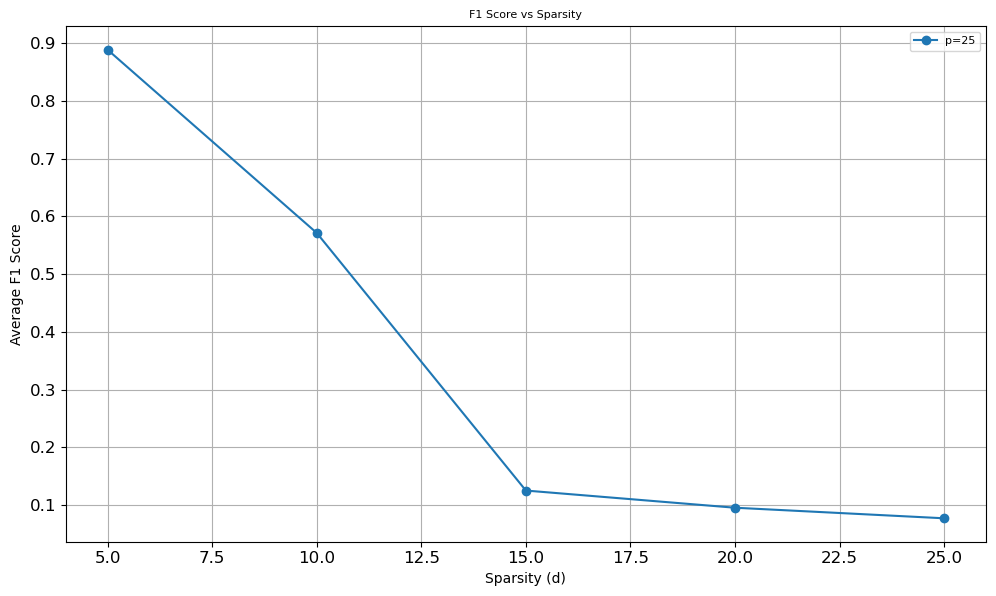

In [44]:
p_list = [25]
d_list = [5, 10, 15, 20, 25]
lambda_val = 0.05
rho_val = 0.5

f1_results = {p: [] for p in p_list}

for p in p_list:
    for d in d_list:
        args = SolverArgs(p=p, d=d, lambda_param=lambda_val, rho=rho_val, num_rep=1)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        f1_results[p].append(metrics['avg_f1'])

# Plotting
plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(d_list, f1_results[p], marker='o', label=f'p={p}')

plt.xlabel('Sparsity (d)')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs Sparsity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tau vs F1

Dimensions of Matrix =  25 Sparsity =  10
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
124987.35797229888 [ 9.99797772e-01  1.53511618e-05  2.37468072e-05  1.68331754e-05
  1.53879133e-06  8.73646525e-06 -1.25426882e-05  1.03556385e-06
  2.79151668e-07  2.47410948e-06 -9.39346914e-07 -7.55274919e-06
  2.23474645e-05 -1.00233289e-06  7.14466377e-06 -1.90387386e-05
  1.15725736e-05  2.43442270e-05  2.00828834e-05 -4.55055053e-06
  6.84932258e-06  3.10737762e-05 -3.43217162e-05 -1.00586454e-05
 -2.35580435e-05]
0
line search
line search
line search
line search
line search
line search
line search
line search
line search
line search
0.004953512106214143 [ 3.43342120e-03  2.49551401e-06  3.71340666e-06  2.51727525e-06
  2.06357248e-07  1.18492586e-06 -4.73318149e-02  1.20802

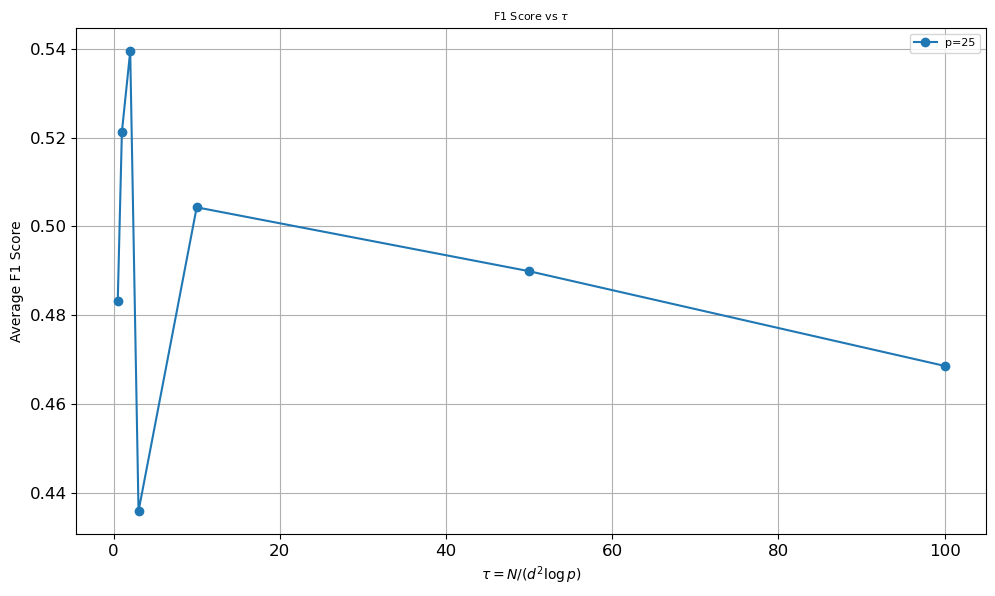

In [ ]:
p_list = [25]
tau = [0.5, 1, 2, 3, 10, 50, 100]
d_fixed = 10
lambda_val = 0.05
rho_val = 1
np.random.seed(0)

f1_results_ratio = {p: [] for p in p_list}

for p in p_list:
    for t in tau:
        args = SolverArgs(p=p, d=d_fixed, const=t, lambda_param=lambda_val, rho=rho_val, num_rep=5)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        f1_results_ratio[p].append(metrics['avg_f1'])

plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(tau, f1_results_ratio[p], marker='o', label=f'p={p}')

plt.xlabel(r"$\tau = N/(d^2 \log p)$")
plt.ylabel('Average F1 Score')
plt.title(r'F1 Score vs $\tau$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.spy(B_mat_symmetric(, 25))